# Predictive Maintenance  - Classification approach

<h3>Task 1 - build a model to answer a question</h3>
<body> question: Model the err, and errf columns for individual 'scanners' to show a expected failure rate of the encoder component. 
Scanners identified into two groups, based on the following criteria and grouping:
<ul>never fail: scanners whom never reach the 12 % range for err</ul>
<ul>routinely fail: scanners whom reach the 12% range for err on a routine basis</ul>
err and errf are both float values, they are loosely tied to each other, and are not a 1 for 1 relationship, e.g. a rising err value doesn't mean a errf value will rise, nor the opposite.  
Failure is defined as a err that is above 12 % and/or a errf that is above 0.5 %

background:  err and errf represent a encoder error rate at which a led light is pulsating into a window barrier.  This barrier, and subsequent calculation, represent the rate of rotation of a component, and the compensated ERRor and ERRor Filtered value. 
</body> 
<h3>task 3 - explain why the model was chosen to answer the question asked </h3>

<h3>task 4 - explain the performance of the model, and of other models that would prove the same question.</h3>

<h3>task-5: Build documentation and share it across.</h3>

<h2>Exploratory Data Analysis</h2>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-whitegrid')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

import re
import mypyutil as mpy

import mypyutil as mpy

In [5]:
df = pd.read_csv("RandomforestAssignment.csv", parse_dates=['date'],infer_datetime_format=True)

In [6]:
df.head(500)

date scanner    min    max   err  pixels   minf   maxf  errf  \
0   2017-12-17    K219  35435  35933  1.40       6  35681  35688  0.02   
1   2017-12-18    H161  35155  36382  3.43      14  35731  35761  0.08   
2   2017-12-18    K211  35305  36042  2.07      43  35692  35739  0.13   
3   2017-12-18    K212  35216  36225  2.82      61  35686  35726  0.11   
4   2017-12-18    K220  35196  36259  2.98      11  35709  35724  0.04   
..         ...     ...    ...    ...   ...     ...    ...    ...   ...   
495 2017-12-29    K250  35232  36040  2.27      17  35696  35709  0.04   
496 2017-12-30    K237  35459  36026  1.59      12  35711  35719  0.02   
497 2017-12-30    K238  35115  36354  3.47       7  35709  35716  0.02   
498 2017-12-30    K239  35169  36391  3.42      21  35721  35728  0.02   
499 2017-12-30    K250  35232  36040  2.27      17  35696  35709  0.04   

                       updated_at  
0    '2017-12-29 16:26:16.475205'  
1    '2017-12-29 16:26:16.872783'  
2    '2017-12-19 18:10:57.453846'  
3     '2017-12-19 18:10:57.45983'  
4    '2017-12-19 18:10:57.464388'  
..                            ...  
495                             ?  
496                             ?  
497                             ?  
498                             ?  
499                             ?  

[500 rows x 10 columns]

__Note:__
__*From the Updated at value we can get the duration of which the scanner worked before doing the measurement*__

In [7]:
df['updated_at'] = np.where(df['updated_at']=='?',df['date'].dt.strftime('%Y-%m-%d %H:%M:%S.%f'), df['updated_at'])

In [8]:
df['updated_at'] = df['updated_at'].apply(lambda x: x.replace("'",""))

In [9]:
df['updated_at']  = pd.to_datetime(df['updated_at'])

In [10]:
type(df['updated_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
df['duration'] = df['updated_at']-df['date']
df['duration'] = df['duration'].apply(lambda x:x.days)

In [12]:
df = df.drop(['updated_at','date'],axis= 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   scanner   2752 non-null   object 
 1   min       2752 non-null   int64  
 2   max       2752 non-null   int64  
 3   err       2752 non-null   float64
 4   pixels    2752 non-null   int64  
 5   minf      2752 non-null   int64  
 6   maxf      2752 non-null   int64  
 7   errf      2752 non-null   float64
 8   duration  2752 non-null   int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 193.6+ KB


<h4>Data Clean-up:  Removing rows which is not having any recorded value </h4>

In [14]:
 df = df.loc[~((df['min']<=0) & (df['max']<=0) & (df['err'] <= 0)),:]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2751
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   scanner   2603 non-null   object 
 1   min       2603 non-null   int64  
 2   max       2603 non-null   int64  
 3   err       2603 non-null   float64
 4   pixels    2603 non-null   int64  
 5   minf      2603 non-null   int64  
 6   maxf      2603 non-null   int64  
 7   errf      2603 non-null   float64
 8   duration  2603 non-null   int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 203.4+ KB


In [16]:
#mpy.add_datepart(df,'updated_at',time=True)

In [17]:
df.head()

scanner    min    max   err  pixels   minf   maxf  errf  duration
0    K219  35435  35933  1.40       6  35681  35688  0.02        12
1    H161  35155  36382  3.43      14  35731  35761  0.08        11
2    K211  35305  36042  2.07      43  35692  35739  0.13         1
3    K212  35216  36225  2.82      61  35686  35726  0.11         1
4    K220  35196  36259  2.98      11  35709  35724  0.04         1

In [18]:
from numpy import absolute
df['MaxMinDiff'] = absolute(df['max']-df['min'])

df['MaxfMinfDiff'] = absolute(df['maxf']-df['minf'])

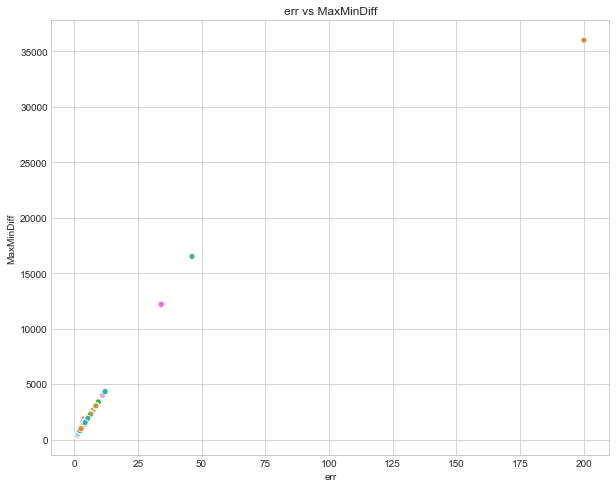

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(10,8))

plt.title('err vs MaxMinDiff')
sns.scatterplot(x=df['err'],y=df['MaxMinDiff'],hue=df['scanner'],legend= False)
plt.xlabel('err')
plt.ylabel('MaxMinDiff')

plt.show()
plt.tight_layout()

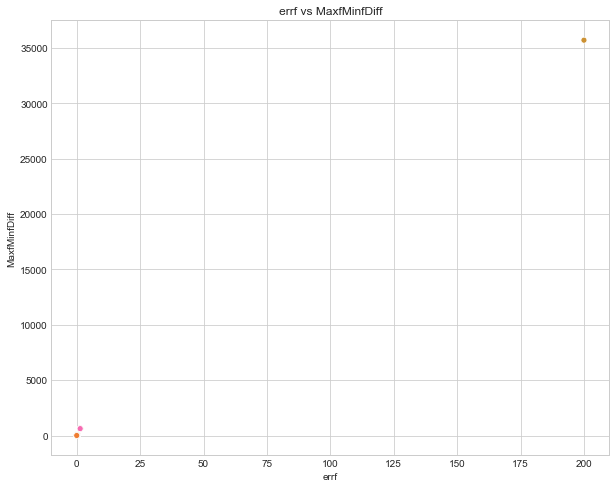

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(10,8))

plt.title('errf vs MaxfMinfDiff')
sns.scatterplot(x=df['errf'],y=df['MaxfMinfDiff'],hue=df['scanner'],legend= False)
plt.xlabel('errf')
plt.ylabel('MaxfMinfDiff')

plt.show()
plt.tight_layout()

<h4>Err and Errf values are dependent on Max min difference of their respective parameters </h4>
<ul>MaxMinDiff value threshold is approximately 4500 beyond which the Err value goes beyond 12% which is failure of the device</ul>
<ul>MaxfMinfDiff value threshold is approximately 150 beyond which the Err value goes beyond 0.5% which is failure of the device</ul>


In [21]:
# Add Failure column which is our output lable 

df['Failure'] = np.where((df['err'] >= 12.0) | (df['errf'] >=0.5),2, 1)
df['Failure'].unique()

array([1, 2])

In [22]:
df['Failure'].value_counts()

1    2591
2      12
Name: Failure, dtype: int64

<h4> In the dataset, we have only 12 rows which has failure scanner data value available </h4>

In [23]:
df.columns

Index(['scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf',
       'duration', 'MaxMinDiff', 'MaxfMinfDiff', 'Failure'],
      dtype='object')

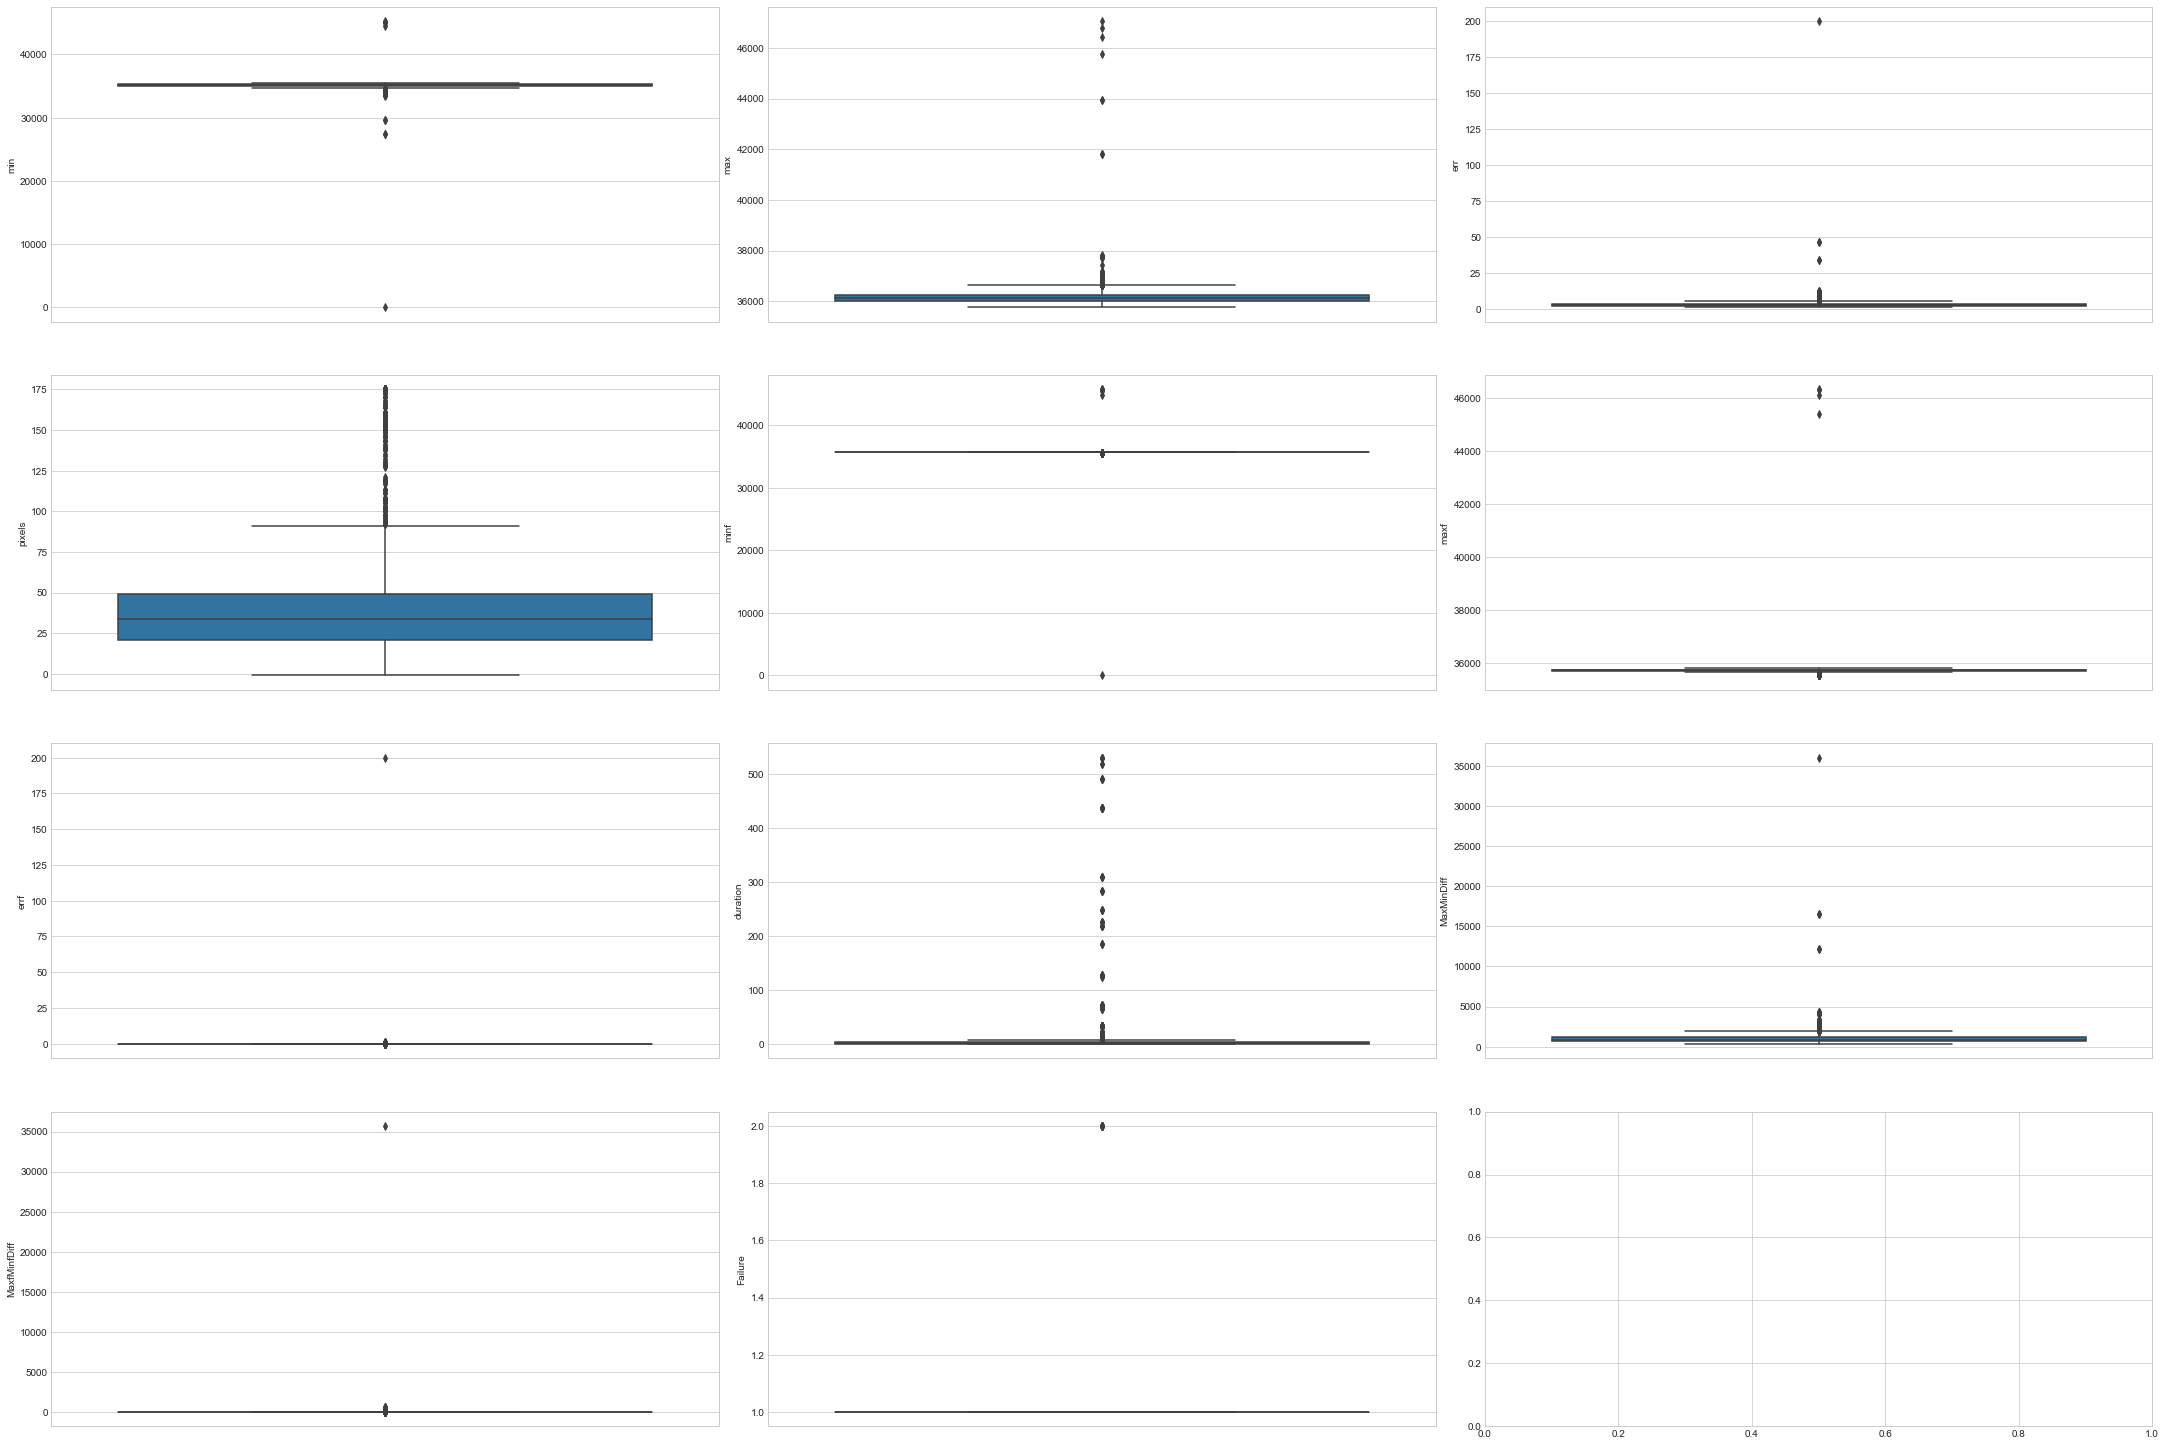

In [24]:
df_copy = df.drop('scanner',axis =1)
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 20))
index = 0
axs = axs.flatten()
for k,v in df_copy.items():
    sns.boxplot(y=k, data=df_copy, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<h3>Note:  Outliers </h3>
<body> Many perameters are not distributed properly, Many outliers, but those are failure cases </body>

In [25]:
df_copy.columns

Index(['min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf', 'duration',
       'MaxMinDiff', 'MaxfMinfDiff', 'Failure'],
      dtype='object')

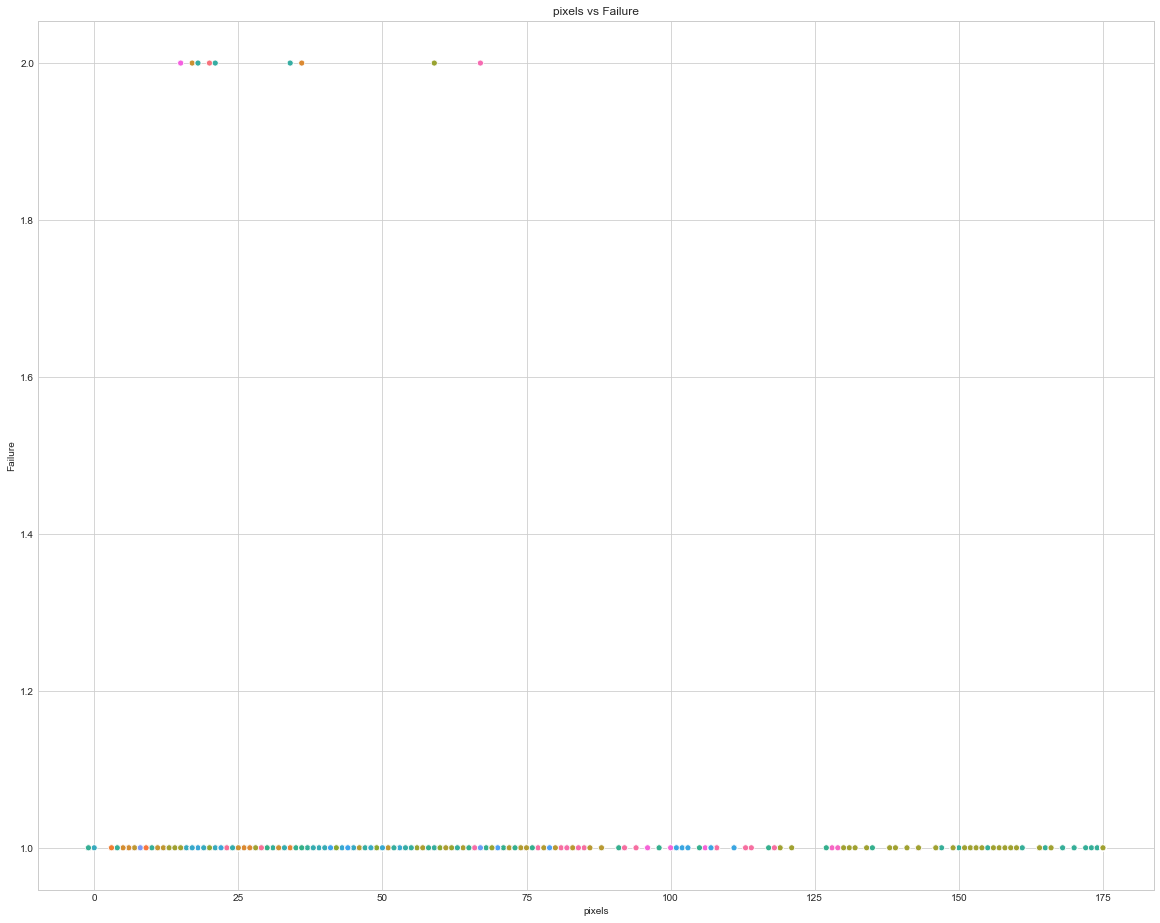

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(20,16))

plt.title('pixels vs Failure')
sns.scatterplot(x=df_copy['pixels'],y=df_copy['Failure'],hue=df['scanner'], legend = False)
plt.xlabel('pixels')
plt.ylabel('Failure')

plt.show()
plt.tight_layout()

<h4>Note : Pixel values are not having influence on the failure </h4>

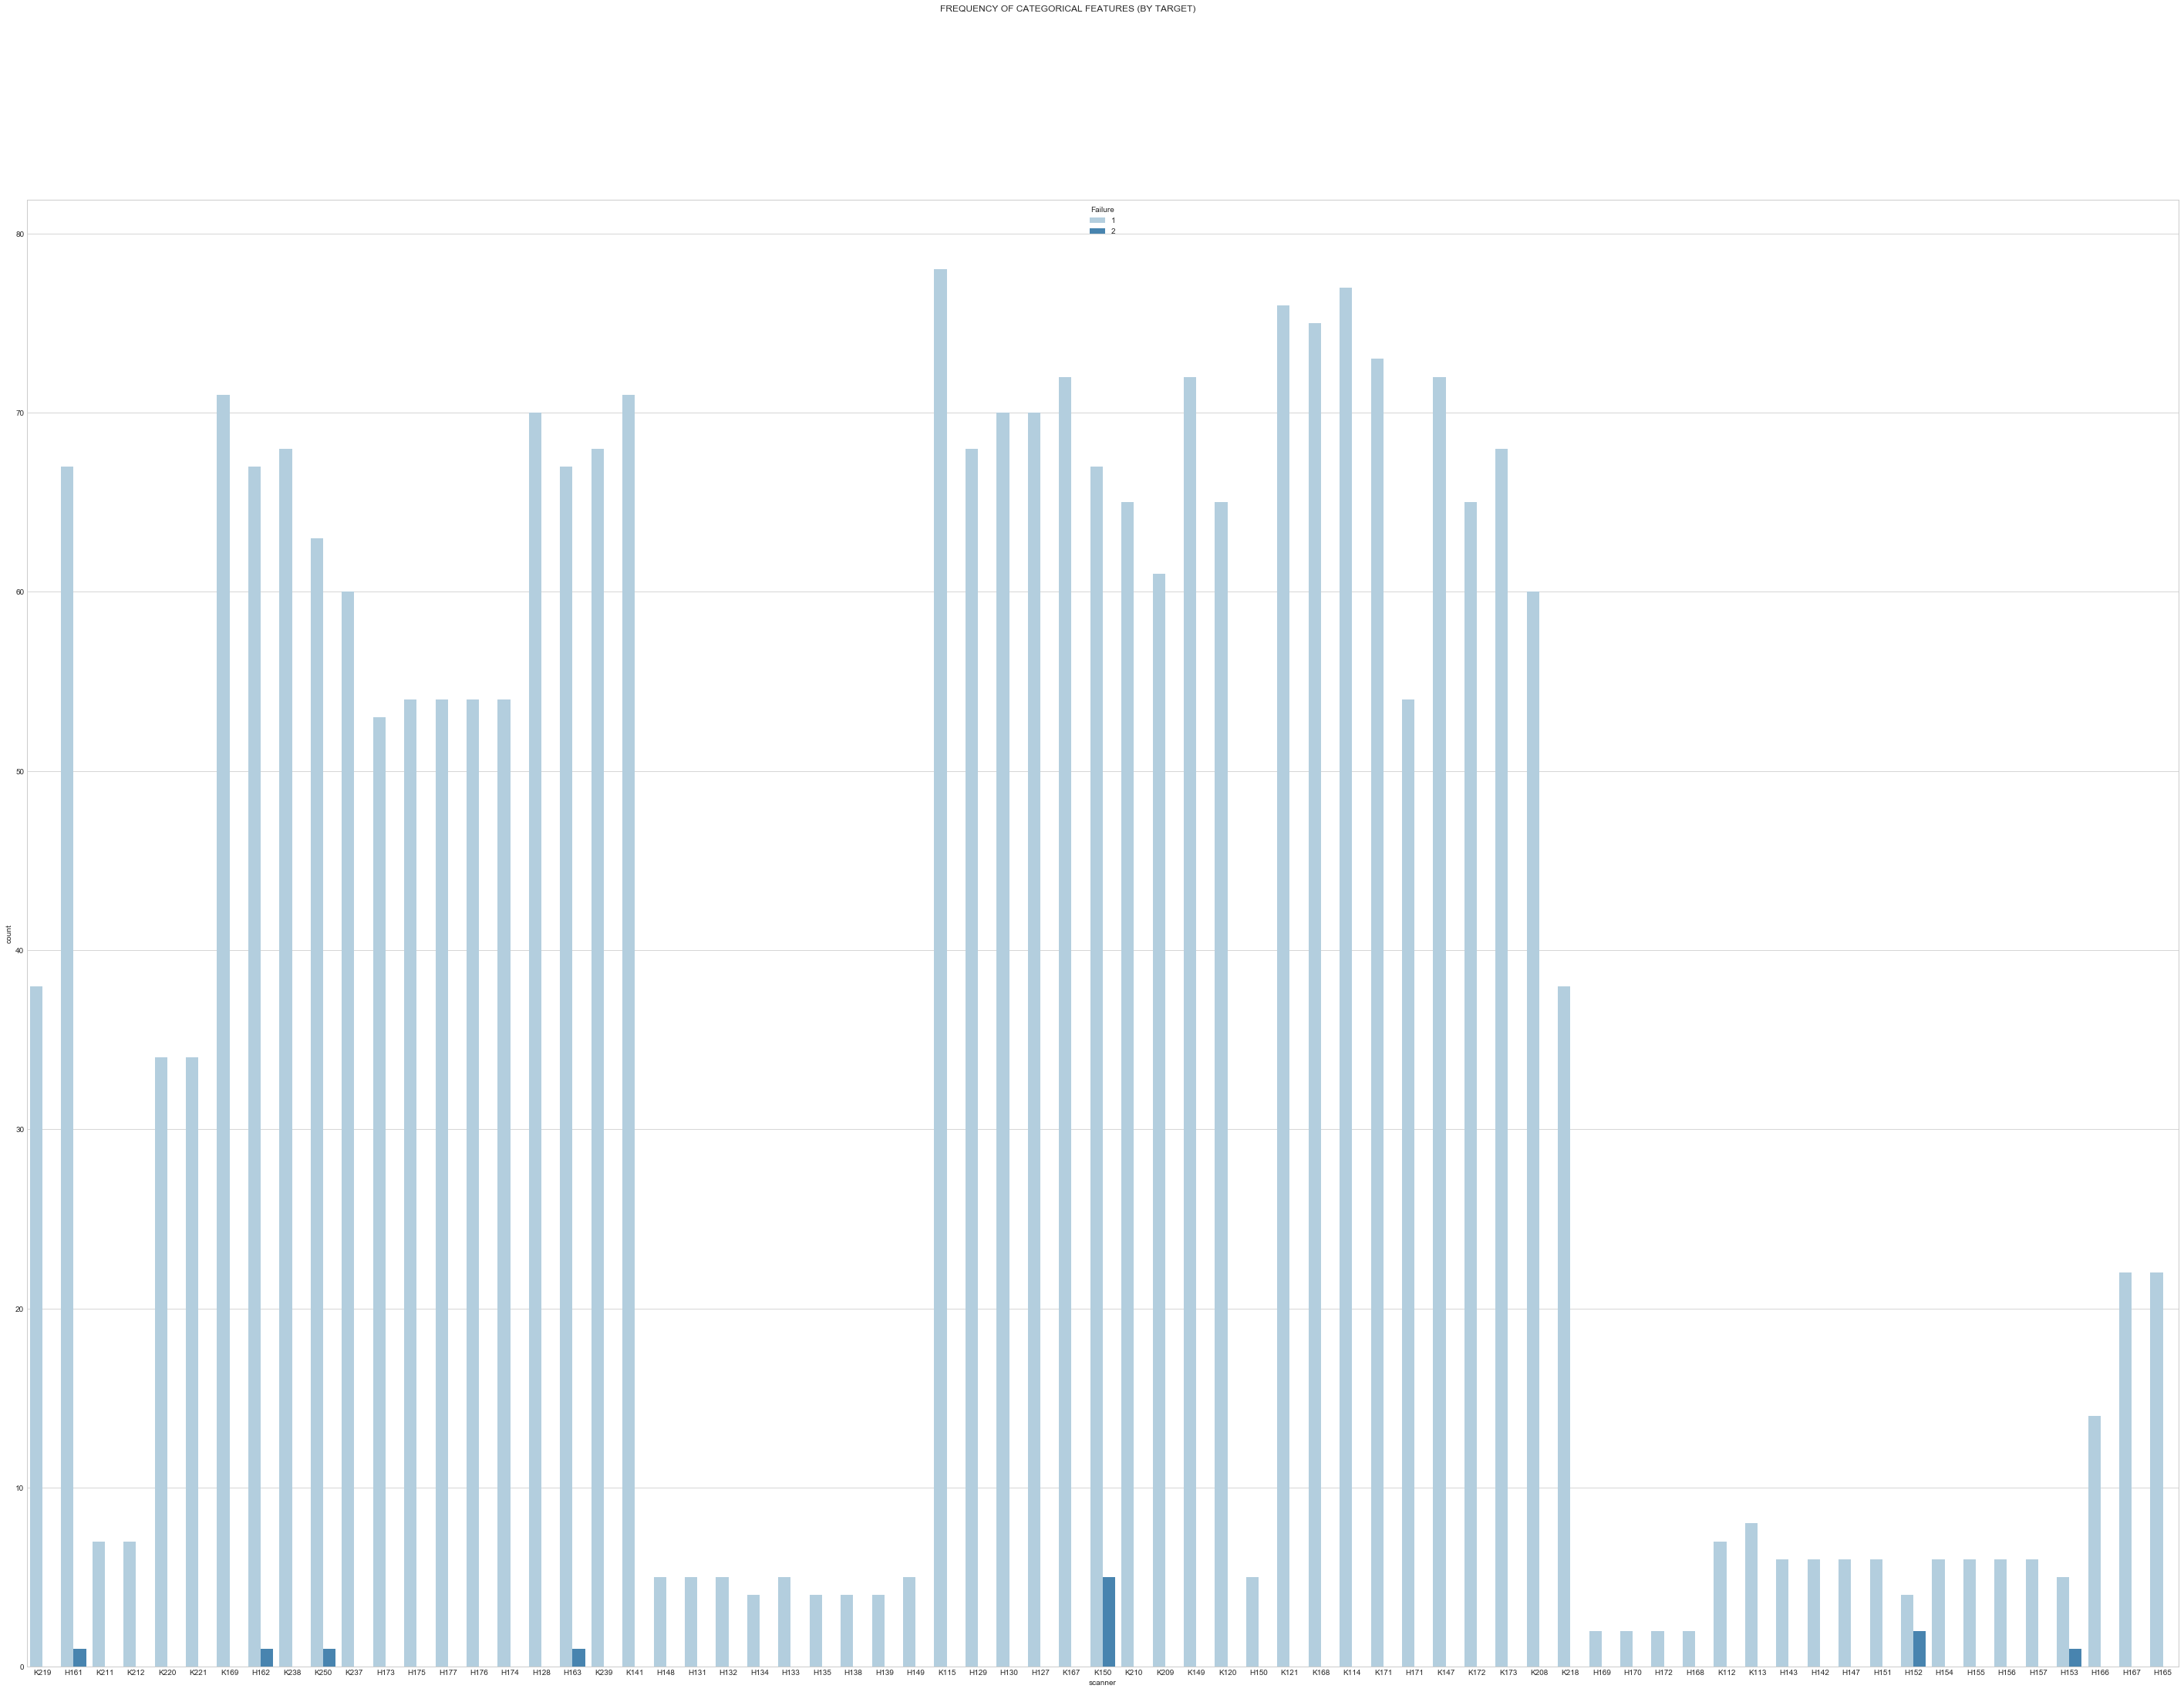

In [27]:
# Creating a new dataframe with categorical variables


f, axes = plt.subplots(1, 1, figsize=(50, 35), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.countplot(x="scanner", hue="Failure", data=df, palette="Blues")


<h4> Note:  The dataset is not having all the failure cases of the scanner or only few of the scanner fails </h4>

In [28]:
df_copy1 = pd.concat([df,pd.get_dummies(df['scanner'], prefix='scanner',dummy_na=False)],axis=1).drop(['scanner'],axis=1)

In [36]:
df_copy1.head()

min      max   err  pixels   minf   maxf  errf  duration  MaxMinDiff  \
0  35435.0  35933.0  1.40       6  35681  35688  0.02        12         498   
1  35155.0  36382.0  3.43      14  35731  35761  0.08        11        1227   
2  35305.0  36042.0  2.07      43  35692  35739  0.13         1         737   
3  35216.0  36225.0  2.82      61  35686  35726  0.11         1        1009   
4  35196.0  36259.0  2.98      11  35709  35724  0.04         1        1063   

   MaxfMinfDiff  ...  scanner_K211  scanner_K212  scanner_K218  scanner_K219  \
0             7  ...             0             0             0             1   
1            30  ...             0             0             0             0   
2            47  ...             1             0             0             0   
3            40  ...             0             1             0             0   
4            15  ...             0             0             0             0   

   scanner_K220  scanner_K221  scanner_K237  scanner_K238  scanner_K239  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             1             0             0             0             0   

   scanner_K250  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 80 columns]

In [30]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2751
Data columns (total 80 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   min           2603 non-null   int64  
 1   max           2603 non-null   int64  
 2   err           2603 non-null   float64
 3   pixels        2603 non-null   int64  
 4   minf          2603 non-null   int64  
 5   maxf          2603 non-null   int64  
 6   errf          2603 non-null   float64
 7   duration      2603 non-null   int64  
 8   MaxMinDiff    2603 non-null   int64  
 9   MaxfMinfDiff  2603 non-null   int64  
 10  Failure       2603 non-null   int32  
 11  scanner_H127  2603 non-null   uint8  
 12  scanner_H128  2603 non-null   uint8  
 13  scanner_H129  2603 non-null   uint8  
 14  scanner_H130  2603 non-null   uint8  
 15  scanner_H131  2603 non-null   uint8  
 16  scanner_H132  2603 non-null   uint8  
 17  scanner_H133  2603 non-null   uint8  
 18  scanner_H134  2603 non-null 

In [34]:
df_copy1['min'] = np.where(df_copy1['min'] == -1,df_copy1['min'].mean(),df_copy1['min'])
df_copy1['max'] = np.where(df_copy1['max'] == -1,df_copy1['max'].mean(),df_copy1['max'])

In [35]:
df_copy1['max'].describe()

count     2603.000000
mean     36200.400307
std        554.719813
min      35761.000000
25%      36007.500000
50%      36119.000000
75%      36264.000000
max      47057.000000
Name: max, dtype: float64

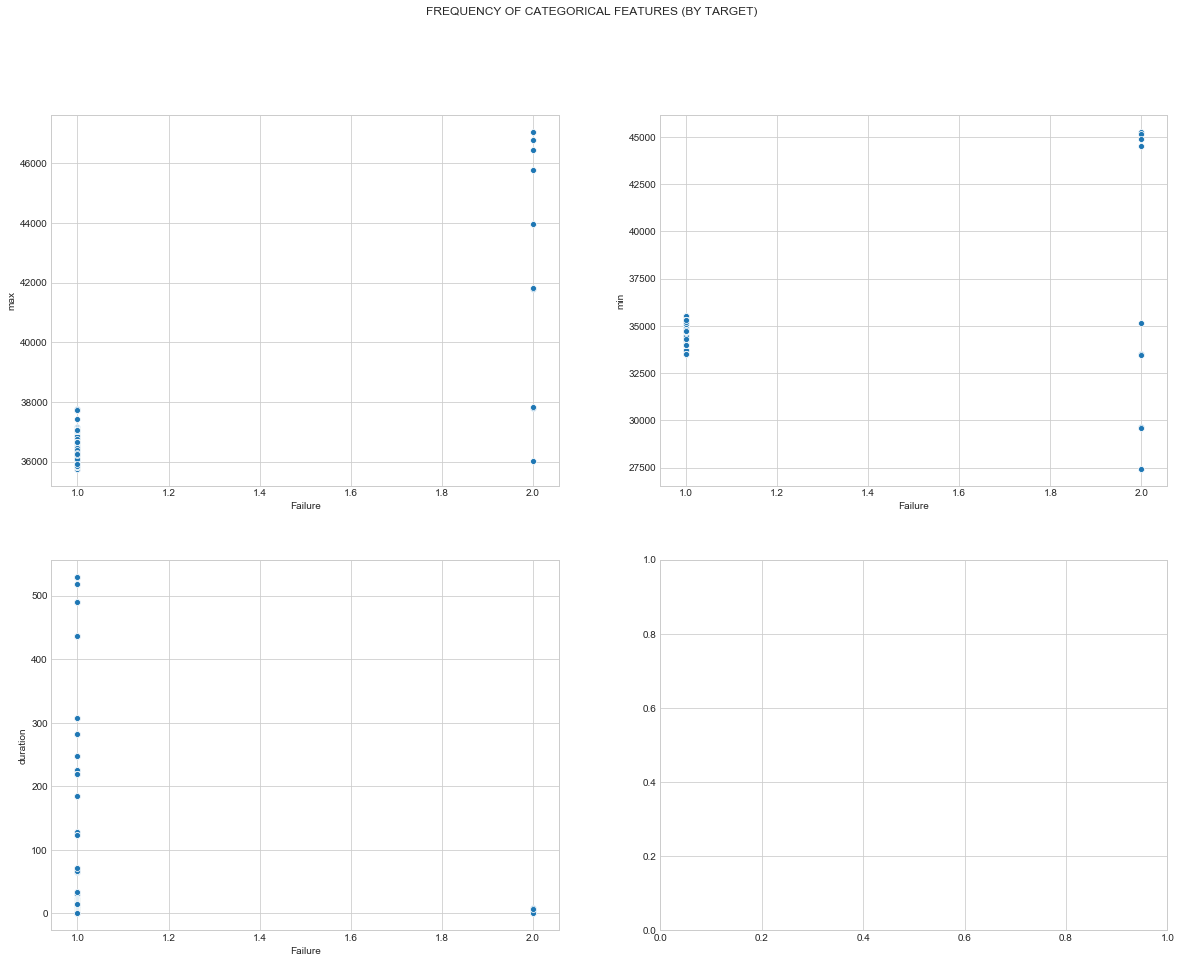

In [37]:
f, axes = plt.subplots(2,2, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['max'],palette ="Set1",ax=axes[0,0])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['min'],palette ="Set1", ax=axes[0,1])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['duration'],palette ="Set1", ax=axes[1,0])

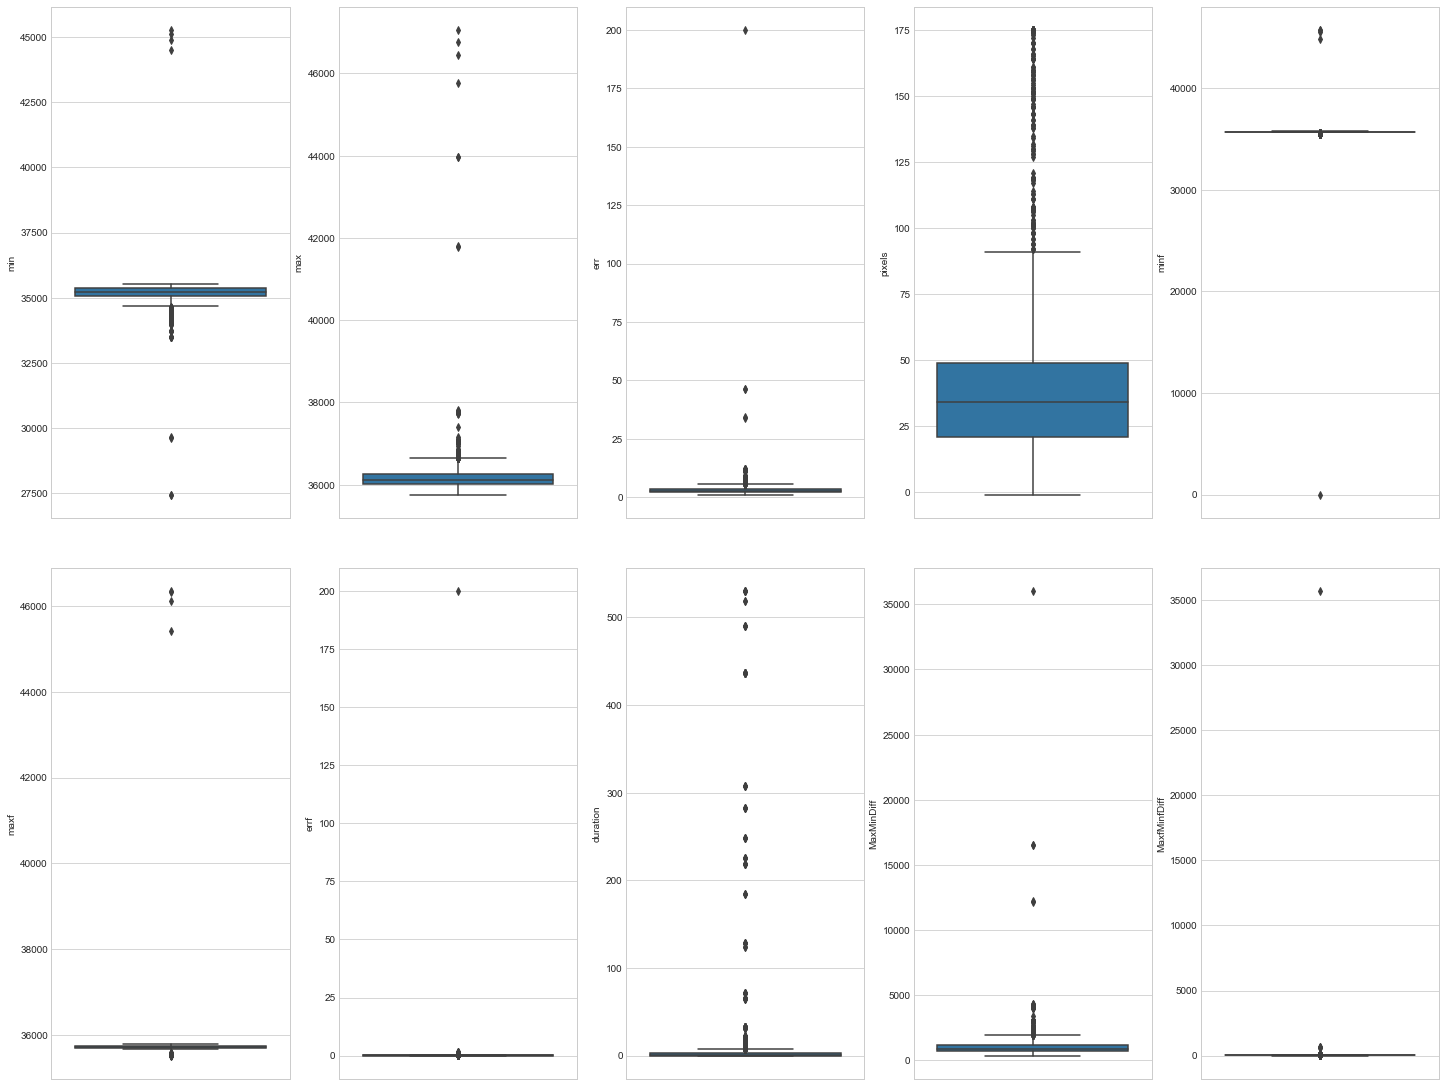

In [45]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 15))
index = 0
axs = axs.flatten()
for k,v in df_copy1.items():
    if k == 'Failure':
        break
    sns.boxplot(y=k, hue= 'Failure',data=df_copy1, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [46]:
df_copy1.columns.size

80

In [49]:
df_copy1['scanner_H150'].value_counts()

0    2598
1       5
Name: scanner_H150, dtype: int64

In [50]:
import plotly.express as px

fig = px.scatter_3d(df_copy1, x='MaxMinDiff', y='err', z='pixels',
              color='scanner_K150')
fig.show()

<h1>Final thought before modeling </h1>
<ul>The difference between Max and Min increases then the scanner will likly towards failure after the value becomes 4000 and above </ul>
<ul>The difference between Maxf and Minf increases then the scanner will likly towards failure after the value becomes 100/90 and above </ul>
<h3>Failure category:</h3>
<ul>Never fail : Failure = 1</ul>
<ul>Routinely fail: Failure = 2</ul>
<ul>Expected to fail/Failing faster: Failure = 3</ul>


In [53]:
df_model = df_copy1.copy()

In [56]:
df_copy1['Failure'] = np.where(((df_copy1['MaxMinDiff'] >= 4000) & (df_copy1['MaxMinDiff'] <= 4280)) |((df_copy1['MaxfMinfDiff'] >= 90) & (df_copy1['MaxfMinfDiff'] <= 120)),3, df_copy1['Failure'])

In [57]:
df_copy1['Failure'].value_counts()

1    2565
3      27
2      11
Name: Failure, dtype: int64

<h2> Data Split </h2>

In [58]:
# Original dataset
X = df_copy1.drop('Failure', axis=1)  
y = df_copy1['Failure']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=45)

<h2>Model Generation and Prediction </h2>

In [78]:
def model_classifier(mod_est): 
      brk_str = '=='*50  
      parameters = {'n_estimators': [50, 150, 250],'max_depth': [4, 8, 16, 32, 64, None]}  
      print(brk_str)
      cv = GridSearchCV(rf, parameters, cv=10)
      cv.fit(X_train, y_train)
      print(brk_str)
      print(cv.best_params_)
      print(brk_str)
      y_pred= cv.predict(X_test)
      print('Accuracy:', metrics.accuracy_score(y_pred,y_test))
     
      cv_scores =cross_val_score(cv, X, y, cv=5)
      print(brk_str)
      print(' Print the 5-fold cross-validation scores')
      print(brk_str)
      print(classification_report(y_test, y_pred))
      print()
      print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),", Standard deviation: {}".format(round(np.std(cv_scores),4)))
      ConfMatrix = confusion_matrix(y_test,cv.predict(X_test))
      print()
      print(ConfMatrix)
      print()
      print(brk_str)

      print('Sample Test check')
      sample_test = df_copy1.loc[(df_copy1['scanner_K150'] == 1) & (df_copy1['Failure'] == 3)]
      ypred_sample = cv.predict(sample_test.drop(['Failure'],axis = 1))
      print(ypred_sample)
      print(brk_str)

<h3>Random Forest Classifier</h3>

In [79]:
model_classifier(RandomForestClassifier())

{'max_depth': 16, 'n_estimators': 250}
Accuracy: 0.9974391805377721
 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9965 , Standard deviation: 0.0026

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


<h3>Gradient Boosting  Classifier</h3>

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
model_classifier(GradientBoostingClassifier())

{'max_depth': 64, 'n_estimators': 50}
Accuracy: 0.9974391805377721
 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9965 , Standard deviation: 0.0026

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


<h2>Conclusion</h2>
<ol>Based on the model estimation both the model's the accuracy and precision and recall values are satisfactory along with cross-validation scores</ol>
<ol>Gradient Boosting model gives results faster than Random Forest.</ol>